# Implementation of _Gaussian Processes for Probabilistic Estimates of Earthquake Ground Shaking: A 1-D Proof-of-Concept_, accepted in ML4PS Workshop @ NeurIPS 2024.

#### Description

This notebook presents a proof-of-concept workflow for probabilistic earthquake ground motion prediction that accounts for inconsistencies between existing seismic velocity models. The approach is based on the probabilistic merging of overlapping seismic velocity models using scalable Gaussian Process (GP) regression. We fit a GP to two synthetic 1-D velocity profiles simultaneously, demonstrating that the predictive uncertainty accounts for the differences between them. We then draw samples of velocity models from the predictive distribution and simulate the acoustic wave equation using each sample as input. This results in a distribution of possible peak ground displacement (PGD) scenarios, reflecting the uncertainty in our knowledge of seismic velocities in the region.

#### Instructions

- By default, the training code is commented out. If you wish to run the training code, simply uncomment it. These cells are indicated.
- Pre-trained models are found in the `models/` directory. These are loaded by default.
- To run the notebook, execute each cell in sequential order. Make sure to run any necessary imports or variable definitions before executing other cells that depend on them.
- If you want to modify the input data or parameters, you can do so in the appropriate cells. Be sure to re-run any cells that depend on the modified data or parameters.

#### Table of Contents

(Note: the hyperlinks have only been tested in VSCode.)

- [Setup, models, and utility functions](#setup-models-and-utility-functions)
    - [Imports](#imports)
    - [Plotting utilities](#plotting-utilities)
    - [GP models](#gp-models)
    - [Data generation utilities](#data-generation-utilities)
- [Workflow](#workflow)
    - [Input data generation](#input-data-generation)
    - [Training the models](#training-the-models)
    - [Generating model predictions](#generating-model-predictions)
    - [Wave propagation hyperparameters and earthquake source](#wave-propagation-hyperparameters-and-earthquake-source)
    - [Sampling velocity models from the PPGPR predictive distribution](#sampling-velocity-models-from-the-ppgpr-predictive-distribution)
    - [Example wave propagation animation](#example-wave-propagation-animation)
    - [Simulating wave equation and recording peak ground motion for velocity model samples](#simulating-wave-equation-and-recording-peak-ground-motion-for-velocity-model-samples)
    - [Simulating wave equation and recording peak ground motion for the two input velocity models](#simulating-wave-equation-and-recording-peak-ground-motion-for-the-two-input-velocity-models)
    - [Calculating probabilistic estimate of peak ground motion and plotting](#calculating-probabilistic-estimate-of-peak-ground-motion-and-plotting)


#### Contributions, Questions, and Issues

If you wish to contribute to this work, have questions, or have issues with running the code, please [get in touch](mailto:sam.scivier@earth.ox.ac.uk).


### Imports

In [1]:
# general imports

import numpy as np
import matplotlib.pyplot as plt

import torch
import gpytorch as gp

from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm
from scipy.interpolate import CubicSpline

from typing import List

import warnings
warnings.filterwarnings('ignore')

In [2]:
# custom imports

from utils.plotting_utils import set_plotting_hyperparameters, truncate_colormap
from utils.data_gen_utils import set_seed, sample_gp_prior, normalise
from utils.gp_models import ApproximateGPModel

### Plotting Setup

In [3]:
# set plotting hyperparameters
set_plotting_hyperparameters()

# set colors
colors = ["#002147", "#E2C044", "#DE1F1F"]

blue_cmap = LinearSegmentedColormap.from_list("custom_cmap", [colors[0], "#ffffff"])

# Truncate the colormap
blue_cmap = truncate_colormap(blue_cmap, 0., 0.8)

## Workflow

[Back to top](#implementation-of-gaussian-processes-for-probabilistic-estimates-of-earthquake-ground-shaking-a-1-d-case-study-in-review)

### Input data generation

In [4]:
# set random seed
 
seed = 0
set_seed(seed)

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [6]:
domain_size = 4  # depth of domain
n_points = 25   # number of data points per input velocity model

# minimum and maximum seismic wave speeds in arbitrary units 
min_velocity = 3
max_velocity = 7

In [7]:
# create a staggered coordinate grid
# GPs can handle non-gridded data, but we use regularly spaced
# data here for simplicity

x1 = torch.linspace(0., 3.9, n_points)  # coordinates of the first input velocity model
x2 = torch.linspace(0.1, 4., n_points)  # coordinates of the second input velocity model

xs = [x1, x2]

In [8]:
n_samples = len(xs)
lengthscale = [0.6, 0.3]    # lengthscale of the kernel function for each input velocity model

# generate velocity models as samples from the GP prior
velocity_models = sample_gp_prior(gp.kernels.RBFKernel(), lengthscale, n_samples=n_samples, x_samples=xs)

print(velocity_models.shape)

torch.Size([2, 25])


In [9]:
# second velocity model is a weighted superposition of the two GP samples
# this creates large-scale similarities and smaller-scale differences between the two models
velocity_models[1] = (1 / 3) * velocity_models[1] + (2 / 3) * velocity_models[0]

# normalise the velocity models to the desired range
velocity_models = normalise(velocity_models, min_velocity, max_velocity)

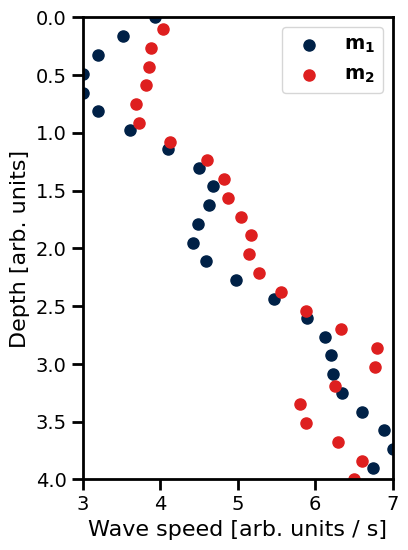

In [10]:
# plot the velocity models

fig, ax = plt.subplots(1, 1, figsize=(4, 6))

ax.scatter(velocity_models[0], xs[0], label=r"$\bf{m}_1$", color=colors[0])
ax.scatter(velocity_models[1], xs[1], label=r"$\bf{m}_2$", color=colors[2])

ax.set(ylim=(0, 4), xlim=(min_velocity, max_velocity))
ax.set_ylabel("Depth [arb. units]")
ax.set_xlabel("Wave speed [arb. units / s]")

ax.invert_yaxis()

ax.legend()

# plt.savefig("./figures/velocity_models.svg", bbox_inches="tight")

plt.show()

### Training the models

[Back to top of section](#workflow)

In [15]:
# set the training data
train_x = torch.cat([x for x in xs], dim=0).to(device)
train_y = torch.cat([y for y in velocity_models], dim=0).to(device)

print(train_x.shape, train_y.shape)

torch.Size([50]) torch.Size([50])


In [16]:
# set initial locations of the inducing points
inducing_points = torch.linspace(0, 4, 20)

# initialize the SVGP and PPGPR models
ppgpr = ApproximateGPModel(inducing_points).to(device)
svgp = ApproximateGPModel(inducing_points).to(device)

# set Gaussian likelihoods for the models
likelihood_ppgpr = gp.likelihoods.GaussianLikelihood().to(device)
likelihood_svgp = gp.likelihoods.GaussianLikelihood().to(device)

In [17]:
# # UNCOMMENT TO TRAIN THE MODEL
# ppgpr.train()
# svgp.train()
# likelihood_ppgpr.train()
# likelihood_svgp.train()

In [18]:
# # UNCOMMENT TO TRAIN THE MODEL

# # set the optimizers for the models
# optimizer_ppgpr = torch.optim.Adam([
#     {"params": ppgpr.parameters()},
#     {"params": likelihood_ppgpr.parameters()},
# ], lr=0.05)

# optimizer_svgp = torch.optim.Adam([
#     {"params": svgp.parameters()},
#     {"params": likelihood_svgp.parameters()},
# ], lr=0.05)

# # define the objective functions
# mll_ppgpr = gp.mlls.PredictiveLogLikelihood(likelihood_ppgpr, ppgpr, num_data=train_y.numel()).to(device)
# mll_svgp = gp.mlls.VariationalELBO(likelihood_svgp, svgp, num_data=train_y.numel()).to(device)

In [19]:
# # UNCOMMENT TO TRAIN THE MODEL
# # train the models
# training_iterations = 4000
# for _ in tqdm(range(training_iterations)):
#     optimizer_ppgpr.zero_grad()

#     output_ppgpr = ppgpr(train_x)

#     loss_ppgpr = -mll_ppgpr(output_ppgpr, train_y)

#     loss_ppgpr.backward()

#     optimizer_ppgpr.step()

# for _ in tqdm(range(training_iterations)):
#     optimizer_svgp.zero_grad()

#     output_svgp = svgp(train_x)

#     loss_svgp = -mll_svgp(output_svgp, train_y)

#     loss_svgp.backward()

#     optimizer_svgp.step()

In [20]:
# # UNCOMMENT IF JUST TRAINED MODEL
# # save the models and likelihoods

# torch.save(ppgpr.state_dict(), "./models/ppgpr.pth")
# torch.save(svgp.state_dict(), "./models/svgp.pth")

# torch.save(likelihood_ppgpr.state_dict(), "./models/likelihood_ppgpr.pth")
# torch.save(likelihood_svgp.state_dict(), "./models/likelihood_svgp.pth")

# load the models and likelihoods

if device.type == "cuda":
    device = torch.device("cpu")

    train_x = train_x.to(device)
    train_y = train_y.to(device)

state_dict_ppgpr = torch.load("./models/ppgpr.pth", map_location=device)
state_dict_svgp = torch.load("./models/svgp.pth", map_location=device)

state_dict_likelihood_ppgpr = torch.load("./models/likelihood_ppgpr.pth", map_location=device)
state_dict_likelihood_svgp = torch.load("./models/likelihood_svgp.pth", map_location=device)

ppgpr = ApproximateGPModel(inducing_points)
ppgpr.load_state_dict(state_dict_ppgpr)

svgp = ApproximateGPModel(inducing_points)
svgp.load_state_dict(state_dict_svgp)

ppgpr.eval()
svgp.eval()

likelihood_ppgpr = gp.likelihoods.GaussianLikelihood()
likelihood_svgp = gp.likelihoods.GaussianLikelihood()

likelihood_ppgpr.load_state_dict(state_dict_likelihood_ppgpr)
likelihood_svgp.load_state_dict(state_dict_likelihood_svgp)

likelihood_ppgpr.eval()
likelihood_svgp.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

### Generating model predictions

[Back to top of section](#workflow)

In [21]:
test_x = torch.linspace(0, 4, 201).to(device)   # test coordinates

# make predictions with the models
with torch.no_grad():

    observed_pred_ppgpr = ppgpr(test_x)  # produce predictions from the PPGPR latent distribution as we ignore the observation noise (latent uncertainty dominates)
    observed_pred_svgp = likelihood_svgp(svgp(test_x))  # produce predictions form the SVGP posterior predictive as the observation noise dominates the uncertainty

# extract the mean and standard deviation of the predictions

mean_ppgpr = observed_pred_ppgpr.mean
std_ppgpr = observed_pred_ppgpr.stddev

mean_svgp = observed_pred_svgp.mean
std_svgp = observed_pred_svgp.stddev

# generate samples from the predictive distributions
out_samples_ppgpr = observed_pred_ppgpr.sample(sample_shape=torch.Size([3]))
out_samples_svgp = observed_pred_svgp.sample(sample_shape=torch.Size([3]))

In [22]:
# create an array that contains the value of the predictive pdf at each depth for velocities between 2 and 8

pdf_ppgpr = torch.zeros(201, 201)
pdf_svgp = torch.zeros(201, 201)

test_velocities = torch.linspace(2, 8, 201)

for i in range(201):

    with torch.no_grad():
        observed_pred_ppgpr = ppgpr(test_x[i].unsqueeze(0))
        observed_pred_svgp = likelihood_svgp(svgp(test_x[i].unsqueeze(0)))

    pdf_ppgpr[i, :] = 1 / (np.sqrt(2 * np.pi) * observed_pred_ppgpr.stddev) * torch.exp(-0.5 * (test_velocities - observed_pred_ppgpr.mean) ** 2 / observed_pred_ppgpr.stddev ** 2)
    pdf_svgp[i, :] = 1 / (np.sqrt(2 * np.pi) * observed_pred_svgp.stddev) * torch.exp(-0.5 * (test_velocities - observed_pred_svgp.mean) ** 2 / observed_pred_svgp.stddev ** 2)

pdf_ppgpr = pdf_ppgpr.numpy().T
pdf_svgp = pdf_svgp.numpy().T

# normalise the pdfs
pdf_ppgpr = pdf_ppgpr / np.max(pdf_ppgpr, axis=0)
pdf_svgp = pdf_svgp / np.max(pdf_svgp, axis=0)

# transform the pdfs so that the values are the distance in standard deviations from the mean
n_sigma_pdf_ppgpr = (- 2 * np.log(pdf_ppgpr)) ** 0.5
n_sigma_pdf_svgp = (- 2 * np.log(pdf_svgp)) ** 0.5

# clip the values to a maximum of 5 standard deviations, and avoid issues caused by division by zero
n_sigma_pdf_ppgpr = np.where(n_sigma_pdf_ppgpr > 5, 5, n_sigma_pdf_ppgpr)
n_sigma_pdf_svgp = np.where(n_sigma_pdf_svgp > 5, 5, n_sigma_pdf_svgp)

### Wave propagation hyperparameters and earthquake source

[Back to top of section](#workflow)

In [23]:
domain_size = 4.
n_points = 201  # number of points in the domain
dx = domain_size / (n_points - 1)   # spatial resolution
eps = 0.6   # Courant number
cmax = 7.   # maximum wave speed
dt = eps * dx / cmax    # temporal resolution
nt = 600    # number of time steps

dominant_frequency = 12. / (nt * dt)    # dominant frequency of the earthquake source
source_time = 0.5 / dominant_frequency  # source time delay

src_idx = int(n_points * 2 / 3)   # source location index

time = np.arange(nt) * dt

In [24]:
def ricker_wavelet(
        time: float,
        frequency: float,
):
    """
    Calculates the Ricker wavelet at a given time and dominant frequency.

    Args:
        time (float): The time at which to calculate the wavelet.
        frequency (float): The dominant frequency of the wavelet.

    Returns:
        float: The value of the Ricker wavelet at the given time and frequency.
        
    """
    t = np.pi * frequency * (time - 1. / frequency)
    return (1. - 2. * t**2) * np.exp(-t**2) * 500.

# generate the source time function
source = np.zeros(nt)
for i in range(nt):
    source[i] = ricker_wavelet(i * dt - source_time, dominant_frequency)

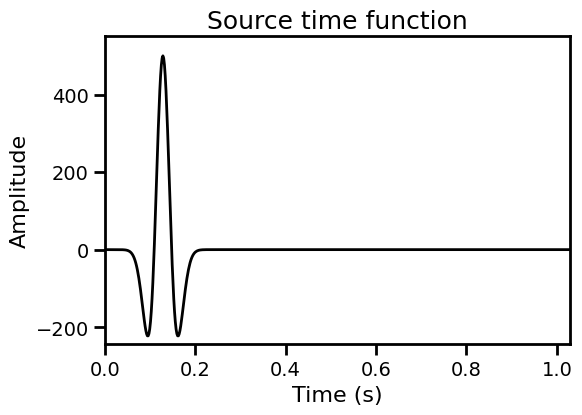

In [25]:
# plot the source time function
plt.figure(figsize=(6, 4))
plt.plot(time, source, color="black")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.ylim(np.min(source) * 1.1, np.max(source) * 1.1)
plt.xlim(0, nt * dt)
plt.title("Source time function")

plt.show()

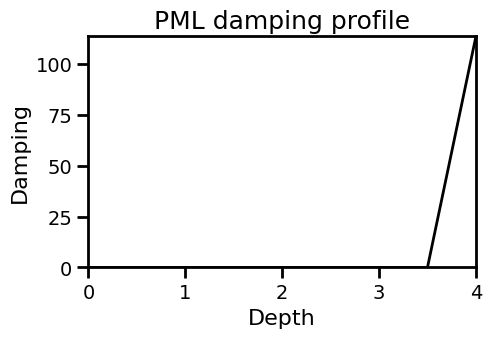

In [26]:
# generate the perfectly-matched layer damping profile for the absorbing boundary (Chern, 2019)

pml_width = 25

max_damping = 20 * (1 + 2 * cmax / 3)

damping = np.zeros((n_points,))

for i in range(pml_width):
    damping[- (i + 1)] = max_damping * (pml_width - i) / pml_width

fig, ax = plt.subplots(1, 1, figsize=(5, 3))

ax.plot(np.linspace(0, 4, n_points), damping, color="black")

ax.set(xlim=(0, 4), ylim=(0, max_damping))

ax.set_title("PML damping profile")
ax.set_xlabel("Depth")
ax.set_ylabel("Damping")

plt.show()

### Sampling velocity models from the PPGPR predictive distribution

[Back to top of section](#workflow)

In [27]:
# generate many samples of velocity models from the PPGPR predictive distribution

n_samples = 200

with torch.no_grad():

    velocity_distribution = ppgpr(test_x)

velocity_samples = velocity_distribution.sample(sample_shape=torch.Size([n_samples])).numpy()

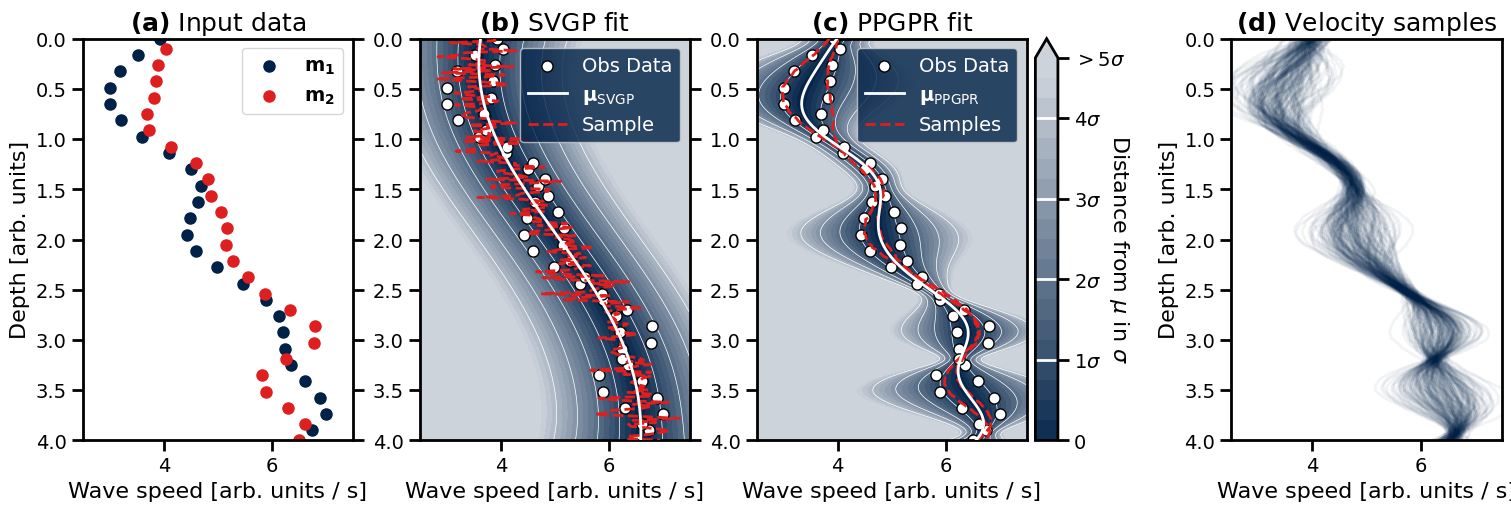

In [ ]:
# plot the input data, the SVGP fit, the PPGPR fit, and the velocity samples from the PPGPR predictive distribution

gs_kw = dict(width_ratios=[12, 12, 12, 1, 0.5, 12])

fig, axs = plt.subplots(1, 6, figsize=(15, 5), constrained_layout=True, gridspec_kw=gs_kw)

for col, ax in enumerate(axs.flat):

    ax.set_xlim(2.5, 7.5)
    ax.set_ylim(0, 4)

    ax.invert_yaxis()

    if col == 0:
        ax.tick_params(right=True)

    if col == 0:
        ax.set_ylabel("Depth [arb. units]")

    if col == 1:
        ax.tick_params(right=True)

    if col != 3:
        ax.set_xlabel("Wave speed [arb. units / s]")

axs[0].scatter(velocity_models[0], xs[0], label=r"$\bf{m}_1$", color=colors[0])
axs[0].scatter(velocity_models[1], xs[1], label=r"$\bf{m}_2$", color=colors[2])

axs[0].legend(loc="upper right")

c = axs[1].contourf(test_velocities, test_x, n_sigma_pdf_svgp.T, levels=20, cmap=blue_cmap, alpha=1., zorder=0, extend="max")
axs[1].contour(test_velocities, test_x, n_sigma_pdf_svgp.T, levels=[1, 2, 3, 4], colors="white", linewidths=0.5, zorder=1)
axs[1].scatter(train_y, train_x, color="white", edgecolors="black", label="Obs Data", zorder=2)
axs[1].plot(mean_svgp, test_x, label=r"$\bf{\mu}_{\text{SVGP}}$", color="white", zorder=4)

axs[1].plot(out_samples_svgp[0], test_x, color=colors[2], ls="--", label=f"Sample", zorder=3)

axs[1].legend(facecolor=colors[0], labelcolor="white", loc="upper right")

c = axs[2].contourf(test_velocities, test_x, n_sigma_pdf_ppgpr.T, levels=20, cmap=blue_cmap, alpha=1., zorder=0, extend="max")
axs[2].contour(test_velocities, test_x, n_sigma_pdf_ppgpr.T, levels=[1, 2, 3, 4], colors="white", linewidths=0.5, zorder=1)
axs[2].scatter(train_y, train_x, color="white", edgecolors="black", label="Obs Data", zorder=2)
axs[2].plot(mean_ppgpr, test_x, label=r"$\bf{\mu}_{\text{PPGPR}}$", color="white", zorder=4)

for i in range(2):
    if i == 0:
        axs[2].plot(out_samples_ppgpr[i], test_x, color=colors[2], ls="--", label=f"Samples", zorder=3)
    else:
        axs[2].plot(out_samples_ppgpr[i], test_x, color=colors[2], ls="--", zorder=3)

axs[2].legend(facecolor=colors[0], labelcolor="white", loc="upper right")

cbar = fig.colorbar(c, cax=axs[3])
cbar.set_ticks([0, 1, 2, 3, 4, 5])
cbar.set_ticklabels([r"0", r"1$\sigma$", r"2$\sigma$", r"3$\sigma$", r"4$\sigma$", r"$>$5$\sigma$"])
cbar.set_label("Distance from $\mu$ in $\sigma$", rotation=270)

axs[3].invert_yaxis()

axs[4].axis("off")

for i in range(1, 5):
    cbar.ax.axhline(i, color="white", lw=2)

for i in range(n_samples):
    axs[5].plot(velocity_samples[i], np.linspace(0, 4, n_points), color=colors[0], alpha=0.05)

axs[5].set_ylabel("Depth [arb. units]")

axs[0].set_title(r"$\bf{(a)}$ Input data")
axs[1].set_title(r"$\bf{(b)}$ SVGP fit")
axs[2].set_title(r"$\bf{(c)}$ PPGPR fit")
axs[5].set_title(r"$\bf{(d)}$ Velocity samples")

# plt.savefig("./figures/data_fit_samples.pdf", bbox_inches="tight")
# plt.savefig("./figures/data_fit_samples.png", bbox_inches="tight")
# plt.savefig("./figures/data_fit_samples.svg", bbox_inches="tight")

plt.show()

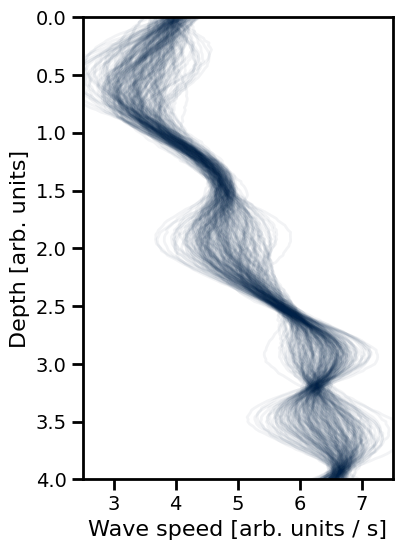

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(4, 6))

n_plot = 200

for i in range(n_plot):
    ax.plot(velocity_samples[i], np.linspace(0, 4, n_points), color=colors[0], alpha=1. / n_plot ** 0.565)

ax.set(xlim=(2.5, 7.5), ylim=(0, 4))
ax.invert_yaxis()

ax.set_ylabel("Depth [arb. units]")
ax.set_xlabel("Wave speed [arb. units / s]")

plt.show()

### Simulating wave equation and recording peak ground motion for velocity model samples

[Back to top of section](#workflow)

In [31]:
rk_alpha = 2. / 3.  # 2nd-order Runge-Kutta alpha parameter (2/3 corresponds to Ralston's method)

c = velocity_samples  # velocity models are samples from the PPGPR predictive distribution

u = np.zeros((n_samples, n_points))  # initialise displacement field
u_old = np.zeros((n_samples, n_points)) # initialise previous displacement field

d2udx2 = np.zeros((n_samples, n_points))    # initialise second spatial derivative of displacement field

# initialise auxiliary variables for the PML absorbing boundary
phi = np.zeros((n_samples, n_points))
psi = np.zeros((n_samples, n_points))

# more auxiliary variables for the PML absorbing boundary
phi_1 = np.zeros((n_samples, n_points))
psi_1 = np.zeros((n_samples, n_points))
phi_2 = np.zeros((n_samples, n_points))
psi_2 = np.zeros((n_samples, n_points))

# Runge-Kutta 2nd-order time integration for the PML absorbing boundary
# initialise RK slopes for auxiliary variables
k1_phi = np.zeros((n_samples, n_points))
k2_phi = np.zeros((n_samples, n_points))
k1_psi = np.zeros((n_samples, n_points))
k2_psi = np.zeros((n_samples, n_points))

phi_psi = np.zeros((n_samples, n_points))

damping_stack = np.stack([damping] * n_samples, axis=0) # stack the damping profile for each velocity model

peak_amplitudes = np.zeros((n_samples, nt))   # initialise peak amplitudes of the displacement field for each velocity model
u_plot = np.zeros((nt, n_points))  # initialise array to store plotting data for a single velocity model

plot_idx = 3    # index of the velocity model to plot the displacement field for

for it in tqdm(range(nt)):

    for i in range(1, n_points - 1):

        # calculate the second spatial derivative of the displacement field
        # three-point centred difference
        d2udx2[:, i] = (u[:, i + 1] - 2 * u[:, i] + u[:, i - 1]) / dx ** 2

        # calculate the auxiliary variables for the PML absorbing boundary
        phi_1[:, i] = - (damping_stack[:, i - 1] * phi[:, i - 1] + damping_stack[:, i] * phi[:, i]) / 2.
        phi_2[:, i] = - (u[:, i + 1] - u[:, i - 1]) / (2. * dx)
        psi_1[:, i] = - (damping_stack[:, i - 1] * psi[:, i] + damping_stack[:, i] * psi[:, i + 1]) / 2.
        psi_2[:, i] = - (u[:, i + 1] - u[:, i - 1]) / (2. * dx)

    k1_phi = phi_1 + phi_2
    k1_psi = psi_1 + psi_2

    for i in range(1, n_points - 1):

        k2_phi[:, i] = - (damping_stack[:, i - 1] * (phi[:, i - 1] + rk_alpha * dt * k1_phi[:, i - 1]) + damping_stack[:, i] * (phi[:, i] + rk_alpha * dt * k1_phi[:, i])) / 2. - (u[:, i + 1] - u[:, i - 1]) / (2. * dx)
        k2_psi[:, i] = - (damping_stack[:, i - 1] * (psi[:, i] + rk_alpha * dt * k1_psi[:, i]) + damping_stack[:, i] * (psi[:, i + 1] + rk_alpha * dt * k1_psi[:, i + 1])) / 2. - (u[:, i + 1] - u[:, i - 1]) / (2. * dx)

    # RK time integration for auxiliary variables
    phi_new = phi + dt * ((1 - 1 / (2 * rk_alpha)) * k1_phi + 1 / (2 * rk_alpha) * k2_phi)
    psi_new = psi + dt * ((1 - 1 / (2 * rk_alpha)) * k1_psi + 1 / (2 * rk_alpha) * k2_psi)

    # add damping for absorbing boundary
    for i in range(1, n_points - 1):

        phi_psi[:, i] = damping_stack[:, i] * psi_new[:, i + 1] - damping_stack[:, i - 1] * phi_new[:, i - 1]
    
    # time integration for displacement field, including absorbing boundary term
    # three-point centred difference
    u_new = 2 * u - u_old + c ** 2 * dt ** 2 * (d2udx2 + phi_psi / dx)

    # free surface boundary condition at x = 0
    # acoustic pressure is zero at the surface, therefore the divergence of the displacement field is zero
    u_new[:, 0] = u_new[:, 1]

    # updating source term
    u_new[:, src_idx] = u_new[:, src_idx] + source[it] / dx * dt ** 2

    # update variables
    u_old, u = u, u_new
    phi_old, phi = phi, phi_new
    psi_old, psi = psi, psi_new

    # update the peak amplitudes of the displacement field for each velocity model
    peak_amplitudes[:, it] = np.maximum(peak_amplitudes[:, it - 1], np.abs(u[:, 0]))

    # update the plotting data for a single velocity model
    u_plot[it, :] = u[plot_idx, :]

  1%|          | 6/600 [00:00<00:10, 56.15it/s]

100%|██████████| 600/600 [00:10<00:00, 59.61it/s]


### Simulating wave equation and recording peak ground motion for the two input velocity models

[Back to top of section](#workflow)

In [33]:
# interpolate the two input models using cubic splines

x_interp = np.linspace(0, 4, n_points)  # interpolation coordinates

interp_inputs = np.zeros((2, n_points))

interp_inputs[0] = CubicSpline(xs[0], velocity_models[0])(x_interp)
interp_inputs[1] = CubicSpline(xs[1], velocity_models[1])(x_interp)

In [34]:
# identical wave propagation simulation as before, but with the interpolated input velocity models

rk_alpha = 2. / 3.

c = interp_inputs

u = np.zeros((2, n_points))
u_old = np.zeros((2, n_points))

d2udx2 = np.zeros((2, n_points))

phi = np.zeros((2, n_points))
psi = np.zeros((2, n_points))

phi_1 = np.zeros((2, n_points))
psi_1 = np.zeros((2, n_points))
phi_2 = np.zeros((2, n_points))
psi_2 = np.zeros((2, n_points))

k1_phi = np.zeros((2, n_points))
k2_phi = np.zeros((2, n_points))
k1_psi = np.zeros((2, n_points))
k2_psi = np.zeros((2, n_points))

phi_psi = np.zeros((2, n_points))

damping_stack = np.stack([damping] * 2, axis=0)

peak_amplitudes_input_models = np.zeros((2, nt))

for it in tqdm(range(nt)):

    for i in range(1, n_points - 1):

        d2udx2[:, i] = (u[:, i + 1] - 2 * u[:, i] + u[:, i - 1]) / dx ** 2

        phi_1[:, i] = - (damping_stack[:, i - 1] * phi[:, i - 1] + damping_stack[:, i] * phi[:, i]) / 2.
        phi_2[:, i] = - (u[:, i + 1] - u[:, i - 1]) / (2. * dx)
        psi_1[:, i] = - (damping_stack[:, i - 1] * psi[:, i] + damping_stack[:, i] * psi[:, i + 1]) / 2.
        psi_2[:, i] = - (u[:, i + 1] - u[:, i - 1]) / (2. * dx)

    k1_phi = phi_1 + phi_2
    k1_psi = psi_1 + psi_2

    for i in range(1, n_points - 1):

        k2_phi[:, i] = - (damping_stack[:, i - 1] * (phi[:, i - 1] + rk_alpha * dt * k1_phi[:, i - 1]) + damping_stack[:, i] * (phi[:, i] + rk_alpha * dt * k1_phi[:, i])) / 2. - (u[:, i + 1] - u[:, i - 1]) / (2. * dx)
        k2_psi[:, i] = - (damping_stack[:, i - 1] * (psi[:, i] + rk_alpha * dt * k1_psi[:, i]) + damping_stack[:, i] * (psi[:, i + 1] + rk_alpha * dt * k1_psi[:, i + 1])) / 2. - (u[:, i + 1] - u[:, i - 1]) / (2. * dx)

    phi_new = phi + dt * ((1 - 1 / (2 * rk_alpha)) * k1_phi + 1 / (2 * rk_alpha) * k2_phi)
    psi_new = psi + dt * ((1 - 1 / (2 * rk_alpha)) * k1_psi + 1 / (2 * rk_alpha) * k2_psi)

    for i in range(1, n_points - 1):

        phi_psi[:, i] = damping_stack[:, i] * psi_new[:, i + 1] - damping_stack[:, i - 1] * phi_new[:, i - 1]
    
    u_new = 2 * u - u_old + c ** 2 * dt ** 2 * (d2udx2 + phi_psi / dx)

    u_new[:, 0] = u_new[:, 1]

    u_new[:, src_idx] = u_new[:, src_idx] + source[it] / dx * dt ** 2

    u_old, u = u, u_new
    phi_old, phi = phi, phi_new
    psi_old, psi = psi, psi_new

    peak_amplitudes_input_models[:, it] = np.maximum(peak_amplitudes_input_models[:, it - 1], np.abs(u[:, 0]))

100%|██████████| 600/600 [00:05<00:00, 117.02it/s]


### Calculating probabilistic estimate of peak ground motion and plotting

[Back to top of section](#workflow)

In [35]:
# calculate statistics of the PGD distribution

median = np.median(peak_amplitudes[:, -1])  # median peak ground displacement

# calulate the middle 70% of the peak ground displacements
lower_bound = np.percentile(peak_amplitudes[:, -1], 15)
upper_bound = np.percentile(peak_amplitudes[:, -1], 85)

d_med_lower = median - lower_bound
d_med_upper = upper_bound - median

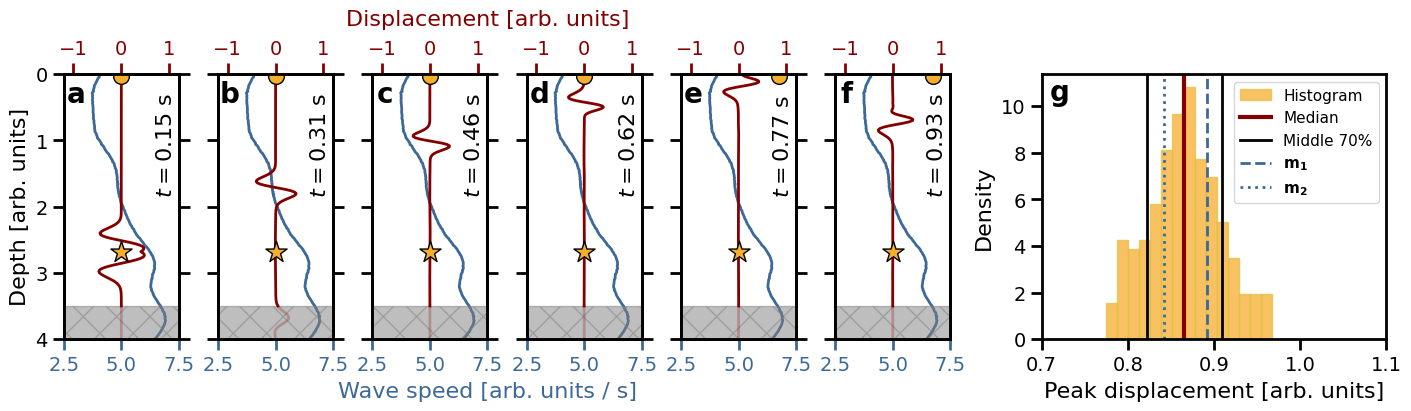

In [ ]:
# plot displacement field at intermediate time steps for one velocity model,
# and the histogram of peak amplitudes for all velocity model samples

x = np.linspace(0., 4., n_points)

gs_kw = dict(width_ratios=[3, 3, 3, 3, 3, 3, 9])

fig, axs = plt.subplots(1, 7, figsize=(14, 4), constrained_layout=True, gridspec_kw=gs_kw)

for col, ax in enumerate(axs.flat[:-1]):

    ax.set_xlim(2.5, 7.5)
    ax.set_ylim(0, 4)

    ax.invert_yaxis()

    ax2 = ax.twiny()

    ax2.set_xlim(-1.2, 1.2)

    if col == 5:
        pass
    else:
        ax.tick_params(right=True)

    if col == 0:
        ax.set_ylabel("Depth [arb. units]")

    if col == 2:
        ax2.set_xlabel("Displacement [arb. units]", color="#830000", labelpad=10, x=1)
        ax.set_xlabel("Wave speed [arb. units / s]", color="#3C6997", labelpad=5, x=1)

    if col != 0:
        ax.set_yticklabels([])

    ax.tick_params(axis='x', labelcolor="#3C6997", color="#3C6997")
    ax2.tick_params(axis='x', labelcolor="#830000", color="#830000")

    N = 90

    ax.text(0.8, 0.55, f"$t = {N * (1 + col) * dt:0.2f}$ s", transform=ax.transAxes, fontsize=16, rotation="vertical")

    ax2.plot(u_plot[N * (1 + col), :-pml_width], x[:-pml_width], color="#830000")
    ax2.plot(u_plot[N * (1 + col), -pml_width - 1:], x[-pml_width - 1:], color="#830000", alpha=0.25)
    ax.plot(velocity_samples[plot_idx], x, color="#3C6997")

    ax2.scatter(0, src_idx * dx, color="#F6AE2D", marker="*", s=256, edgecolor="black", zorder=5)

    ax2.scatter(peak_amplitudes[plot_idx, N * (1 + col)], 0.025, color="#F6AE2D", marker="o", s=128, edgecolor="black", zorder=2)

    ax2.fill_between([-1.2, 1.2], domain_size - pml_width * dx, 4, color="tab:grey", alpha=0.5, hatch="x")

axs[-1].hist(peak_amplitudes[:, -1], bins=15, density=True, color="#F6AE2D", alpha=0.75, label="Histogram", edgecolor=colors[1])

axs[-1].axvline(median, color="#830000", lw=3, label="Median")
axs[-1].axvline(lower_bound, color="black", lw=2, label="Middle 70%")
axs[-1].axvline(upper_bound, color="black", lw=2)

axs[-1].axvline(peak_amplitudes_input_models[0, -1], color="#3C6997", lw=2, ls="--", label=r"$\bf{m}_1$")
axs[-1].axvline(peak_amplitudes_input_models[1, -1], color="#3C6997", lw=2, ls=":", label=r"$\bf{m}_2$")

# axs[-1].set_xlim([median - 4 * d_med_lower, median + 4.5 * d_med_upper])
axs[-1].set_xlim([0.7, 1.1])

# axs[-1].set_yticks([])
axs[-1].set_xlabel("Peak displacement [arb. units]", labelpad=5)
axs[-1].set_ylabel("Density", labelpad=5)

axs[-1].legend(fontsize=11)

lposx = 0.1
lposy = 0.925

axs[0].text(lposx, lposy, r"$\bf{a}$", transform=axs[0].transAxes, fontsize=20, ha="center", va="center")
axs[1].text(lposx, lposy, r"$\bf{b}$", transform=axs[1].transAxes, fontsize=20, ha="center", va="center")
axs[2].text(lposx, lposy, r"$\bf{c}$", transform=axs[2].transAxes, fontsize=20, ha="center", va="center")
axs[3].text(lposx, lposy, r"$\bf{d}$", transform=axs[3].transAxes, fontsize=20, ha="center", va="center")
axs[4].text(lposx, lposy, r"$\bf{e}$", transform=axs[4].transAxes, fontsize=20, ha="center", va="center")
axs[5].text(lposx, lposy, r"$\bf{f}$", transform=axs[5].transAxes, fontsize=20, ha="center", va="center")
axs[6].text(0.05, lposy, r"$\bf{g}$", transform=axs[6].transAxes, fontsize=20, ha="center", va="center")

# plt.savefig("./figures/wavefield_histogram.pdf", bbox_inches="tight")
# plt.savefig("./figures/wavefield_histogram.png", bbox_inches="tight")

plt.show()